# Drift Model Testing

__Intended Process:__
- UDD format data --> generate drift times (t1 - t0) then input into the equation to get drift radii (and uncertainties)
- use same data and get simulated radii from existing falaise
- plot radii versus each other to see how the models compare
- "Truth data" from simulations; see quantitatively how well Betsy's drift model works to estimate radius, get a quantitative result for how well it works compared to existing falaise

Next steps:  
- quantify impact of implementing more detailed electric field
- track fitting?

_Imports_

In [202]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as tm
import seaborn as sns
sns.set_theme()

_Importing the UDD ROOT file with uproot_

In [2]:
data = uproot.open('snemo_run-840_udd.root')

_Shows all branches in the 'SimData;1' branch. Note: 'SimData;1' and 'SimData;2' appear to be the same from preliminary tests._

In [78]:
data['SimData;1'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
header.runnumber     | int32_t                  | AsDtype('>i4')
header.eventnumber   | int32_t                  | AsDtype('>i4')
header.date          | int32_t                  | AsDtype('>i4')
header.runtype       | int32_t                  | AsDtype('>i4')
header.simulated     | bool                     | AsDtype('bool')
header.real          | bool                     | AsDtype('bool')
tracker.nohits       | int32_t                  | AsDtype('>i4')
tracker.id           | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.module       | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.side         | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.layer        | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
tracker.column       | std::vector<int32_t>     | AsJagge

In [69]:
# testing values of variables
# 0 not picked for a particular reason -- times should be so close together that it's below uncertainty levels
trigger_times = data['SimData;1']['digicalo.timestamp'].array(library='np')[0]
trigger_times[0]

adjustment = data['SimData;1']['digicalo.lttimecounter'].array(library='np')[0]

In [75]:
data['SimData;1']['digicalo.lttriggercounter'].array(library='np')[0]

array([232, 286], dtype=uint16)

In [175]:
test_list = []

timestamp_1 = data['SimData;1']['digitracker.side'].array(library='np')[0]

test_list.extend(np.array(timestamp_1, dtype='float').tolist())

In [177]:
timestamp_1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [176]:
new_list = [x for [x] in timestamp_1]

TypeError: cannot unpack non-iterable numpy.int32 object

In [170]:
test_ev_list = [3] *3

In [172]:
test_ev_list.extend(['n']*5)

In [173]:
test_ev_list

[3, 3, 3, 'n', 'n', 'n', 'n', 'n']

In [23]:
anode_times = data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[0]
anode_times_2 = data['SimData;1']['digitracker.anodetimestampR1'].array(library='np')[0]

In [73]:
# R0 conversion from clock ticks to us
(np.array(anode_times[0]).item() - (trigger_times[0] - adjustment[0])/2)*12.5*10**(-3)

37334.11875

In [118]:
id_branch = data['SimData;1']['digitracker.id'].array(library='np')
num_events = np.arange(len(id_branch))
test_events = np.arange(100)

In [178]:
# BEST METHOD!!!
# do I want to print after each iteration? If yes, keep True
verbose = True

# timing (start time) information here
start = tm.time()

# initializing lists to be added as data in the final dataframe
exceptions = []
event_nums = []
ids = []
sides = []
layers = []
columns = []
R0s = []
trigger_times = []

# loop to add all the datapoints into entries in the lists -- converts the root 'branch' format to a single
# list for each variable (so different events no longer have separate arrays)
# test_events determines the number of events to convert into dataframe format
for n in test_events:
    # indicates how many hits occur in the given event
    id_list = np.array(id_branch[n], dtype='int')
    num_hits = len(id_list)
    
    # calling information from the data file -- one array per variable per event
    ev_sides = data['SimData;1']['digitracker.side'].array(library='np')[n]  # French side = 1, Italian = 0
    ev_layers = data['SimData;1']['digitracker.layer'].array(library='np')[n]  # Layer 0 near source foil, layer 8 by calo 
    ev_columns = data['SimData;1']['digitracker.column'].array(library='np')[n]  # Column 0 on mountain side, col 112 on tunnel side
    ev_R0s = data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[n]  # R0 timestamps from anode (clock ticks), tail end of drift time
    ev_ids = data['SimData;1']['digitracker.id'].array(library='np')[n]  # Hit IDs 
    
    # appending data to respective lists
    # use .extend() to append lists rather than individual items
    event_nums.extend([n] * num_hits)  # all hits in each iteration should have the same event ID, so add num_hits IDs to the list
    trigger_times.extend([(data['SimData;1']['digicalo.timestamp'].array(library='np')[n][0] - 44)/2] * num_hits)  # using the first calorimeter
    # timestamp arbitrarily as the trigger time. The calorimeter clock runs twice as fast as the tracker clock, so divide the timestamp by 2
    # and include an offset of - 44 ticks due to 125 ns offset of calorimeter timestamp compared to the signal peak
    sides.extend(ev_sides)
    layers.extend(ev_layers)
    columns.extend(ev_columns)
    R0s.extend([r for [r] in ev_R0s])  # this format since ev_R0s is of the form [[#], [#], ...], so need to get rid of extra brackets
    ids.extend(ev_ids)
    
    # controls printing after each iteration
    if verbose is True:
        print(n + 1, 'of', len(test_events), 'complete')

# end time and printing runtime
end = tm.time()
print('Runtime:', (end - start)/60, 'minutes')

1 of 100 complete
2 of 100 complete
3 of 100 complete
4 of 100 complete
5 of 100 complete
6 of 100 complete
7 of 100 complete
8 of 100 complete
9 of 100 complete
10 of 100 complete
11 of 100 complete
12 of 100 complete
13 of 100 complete
14 of 100 complete
15 of 100 complete
16 of 100 complete
17 of 100 complete
18 of 100 complete
19 of 100 complete
20 of 100 complete
21 of 100 complete
22 of 100 complete
23 of 100 complete
24 of 100 complete
25 of 100 complete
26 of 100 complete
27 of 100 complete
28 of 100 complete
29 of 100 complete
30 of 100 complete
31 of 100 complete
32 of 100 complete
33 of 100 complete
34 of 100 complete
35 of 100 complete
36 of 100 complete
37 of 100 complete
38 of 100 complete
39 of 100 complete
40 of 100 complete
41 of 100 complete
42 of 100 complete
43 of 100 complete
44 of 100 complete
45 of 100 complete
46 of 100 complete
47 of 100 complete
48 of 100 complete
49 of 100 complete
50 of 100 complete
51 of 100 complete
52 of 100 complete
53 of 100 complete
54

In [192]:
# makes the dataframe from the lists made in the processing cell above
event = pd.DataFrame(data={'Event':event_nums, 'ID':ids, 'Side':sides, 'Layer':layers, 'Column':columns, 'R0':R0s, 'Trigger_time':trigger_times})

event.head()

,Event,ID,Side,Layer,Column,R0,Trigger_time
0,0,0,1,0,7,847289447,847289131.5
1,0,1,1,8,0,847289127,847289131.5
2,0,2,1,5,3,847289197,847289131.5
3,0,3,1,6,2,847289122,847289131.5
4,0,4,1,1,7,847289281,847289131.5


In [208]:
event.to_csv('100_events.csv', index=False)

In [ ]:
# pandas concat method -- original, longest version
# loops over events and hits, makes lists and a dataframe of those lists for each event then concatenates the new dataframe to the existing one
# takes forever

start = tm.time()
exceptions = []
verbose = True
events = pd.DataFrame(columns=['Event', 'ID', 'Side', 'Layer', 'Column', 'R0', 'R1'])

for n in test_events:
    id_list = np.array(id_branch[n], dtype='int')
    num_hits = np.arange(len(id_list))
    
    for k in num_hits: 
        try:
            side = np.array(data['SimData;1']['digitracker.side'].array(library='np')[n], dtype='bool')[k].item()
            layer = np.array(data['SimData;1']['digitracker.layer'].array(library='np')[n], dtype='int')[k].item()
            column = np.array(data['SimData;1']['digitracker.column'].array(library='np')[n], dtype='int')[k].item()
            R0 = np.array(data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[n], dtype='float')[k].item()
            R1 = np.array(data['SimData;1']['digitracker.anodetimestampR1'].array(library='np')[n], dtype='float')[k].item()
            id_var = id_list[k].item()

            event = pd.DataFrame(data={'Event':[n], 'ID':[id_var], 'Side':[side], 'Layer':[layer], 'Column':[column], 'R0':[R0], 'R1':[R1]})

            events = pd.concat([events, event], axis=0, ignore_index=True)
            
        except:
            exceptions.append((n, k))
    if verbose is True:
        print(n + 1, 'of', len(test_events), 'complete')

end = tm.time()
print('Runtime:', (end - start)/60, 'minutes')

1 of 100 complete
2 of 100 complete
3 of 100 complete
4 of 100 complete
5 of 100 complete
6 of 100 complete


In [28]:
# list method

In [119]:
# list method; slightly better than pandas method -- appends individual datapoints to lists by looping over events and hits
# still takes way too long

start = tm.time()
exceptions = []
verbose = True
events = pd.DataFrame(columns=['Event', 'ID', 'Side', 'Layer', 'Column', 'R0', 'R1'])
event_nums = []
ids = []
sides = []
layers = []
columns = []
R0s = []
trigger_times = []


for n in test_events:
    id_list = np.array(id_branch[n], dtype='int')
    num_hits = np.arange(len(id_list))
    
    for k in num_hits: 
        try:
            sides.append(np.array(data['SimData;1']['digitracker.side'].array(library='np')[n], dtype='bool')[k].item())
            layers.append(np.array(data['SimData;1']['digitracker.layer'].array(library='np')[n], dtype='int')[k].item())
            columns.append(np.array(data['SimData;1']['digitracker.column'].array(library='np')[n], dtype='int')[k].item())
            R0s.append(np.array(data['SimData;1']['digitracker.anodetimestampR0'].array(library='np')[n], dtype='float')[k].item())
            ids.append(id_list[k].item())
            event_nums.append(n)
            trigger_times.append(data['SimData;1']['digicalo.timestamp'].array(library='np')[n][0]/2)
        except:
            exceptions.append((n, k))
    if verbose is True:
        print(n + 1, 'of', len(test_events), 'complete')

end = tm.time()
print('Runtime:', (end - start)/60, 'minutes')

1 of 100 complete
2 of 100 complete
3 of 100 complete
4 of 100 complete
5 of 100 complete
6 of 100 complete
7 of 100 complete
8 of 100 complete
9 of 100 complete
10 of 100 complete
11 of 100 complete
12 of 100 complete
13 of 100 complete
14 of 100 complete
15 of 100 complete
16 of 100 complete
17 of 100 complete
18 of 100 complete
19 of 100 complete
20 of 100 complete
21 of 100 complete
22 of 100 complete
23 of 100 complete
24 of 100 complete
25 of 100 complete
26 of 100 complete
27 of 100 complete
28 of 100 complete
29 of 100 complete
30 of 100 complete
31 of 100 complete
32 of 100 complete
33 of 100 complete
34 of 100 complete
35 of 100 complete
36 of 100 complete
37 of 100 complete
38 of 100 complete
39 of 100 complete
40 of 100 complete
41 of 100 complete
42 of 100 complete
43 of 100 complete
44 of 100 complete
45 of 100 complete
46 of 100 complete
47 of 100 complete
48 of 100 complete
49 of 100 complete
50 of 100 complete
51 of 100 complete
52 of 100 complete
53 of 100 complete
54

In [121]:
# dictionary for a, b values
# each cell type has 9 values -- 3 sets of a, b pairs corresponding to 3 pressures (850, 880, 910) and the tx value for 
# each pressure in the third entry of each tuple

# 'entry' : [(a_850, b_850, tx_850), (a_880, b_880, tx_880), (a_910, b_910, tx_910)]
ab_vals = {'center_in': [(8.28, -0.9, 2.95), (8.53, -0.9, 2.97), (8.77, -0.9, 3.07)],
           'center_out': [(3.86, -1.99, 2.95), (4.19, -1.93, 2.97), (4.55, -1.9, 3.06)],
           'edge_in': [(8.05, -0.9, 3.73), (8.35, -0.92, 4.15), (8.56, -0.9, 4.12)],
           'edge_out': [(3.34, -2.04, 3.73), (3.39, -2.07, 4.15), (4.03, -1.91, 4.12)],
           'corner_in': [(7.66, -0.87, 3.34), (7.92, -0.87, 3.45), (8.16, -0.87, 3.59)],
           'corner_out': [(5.18, -1.4, 3.34), (4.94, -1.48, 3.45), (5.25, -1.45, 3.59)]
          }

In [122]:
# r(t) = (t/a)**(1/(1-b))

def define_io(t_drift, tx):
    """ Defines whether the particle is in the inner or outer section of the cell.
    param t_drift: The measured drift time (t1 - t0)
    type t_drift: float
    param tx: The reference value of t
    type t_drift: float
    """
    if t_drift > tx:
        inner = False
    else:
        inner = True
    return inner

def find_params(inner, region, pressure):
    """ Consults the ab_vals dictionary to determine a and b parameter values.
    param inner: Defines where the particle is within the cell
    type inner: bool
    param region: Defines the cell region as 'center', 'edge', or 'corner'
    type region: str
    param pressure: Defines the pressure within the tracker (850, 880, or 910)
    type pressure: float
    """
    cell_type = region
    
    if inner is True: 
        cell_type.append('_in')
    else:
        cell_type.append('_out')
        
    if pressure == 850:
        n = 0
    if pressure == 880:
        n = 1
    if pressure == 910:
        n = 2 
        
    params = ab_vals(cell_type[n])
    a = params[0]
    b = params[1]
    tx = params[2]
    
    return params

# since defining the above function, can remove cell_type and pressure from calc_radius and just reference find_params instead

def calc_radius(t_drift, cell_type='center_in', pressure=880):
    """ Calculated the radius of the particle based on drift time and cell conditions.
    param t_drift: The measured drift time (t1 - t0)
    type t_drift: float
    param cell_type: indicates what type of cell the particle is in, references an entry in the ab_vals dictionary
    type cell_type: str, kwarg
    param pressure: indicates the pressure in the tracking chamber, determines which tuple in the cell type dictionary entry should be used 
                    to define a and b
    type pressure: float, kwarg
    """
    if pressure == 850:
        n = 0
    if pressure == 880:
        n = 1
    if pressure == 910:
        n = 2
    
    params = ab_vals[cell_type][n]
    a = params[0]
    b = params[1]
    
    rad = (t_drift / a)**(1 / (1 + 0.9))
    return rad

def calc_uncertainty():
    pass

In [193]:
# calculates drift time here
# need to convert clock ticks into us by using the *12.5 conversion from ticks to ns then *10^(-3) to convert ns to us

dts = (event['R0'] - event['Trigger_time'])*12.5*10**(-3)  # calculates drift time
Drift_time = pd.Series(data=dts, name='Drift_time')  # makes the drift times a series

events_df = pd.concat([event, Drift_time], axis=1)  # concatenates drift time series to existing dataframe

In [201]:
events_df.head()

,Event,ID,Side,Layer,Column,R0,Trigger_time,Drift_time,Radius
0,0,0,1,0,7,847289447,847289131.5,3.94375,0.666290
1,0,1,1,8,0,847289127,847289131.5,-0.05625,NaN
2,0,2,1,5,3,847289197,847289131.5,0.81875,0.291284
3,0,3,1,6,2,847289122,847289131.5,-0.11875,NaN
4,0,4,1,1,7,847289281,847289131.5,1.86875,0.449727


In [200]:
# little code snippet to show how to select things from the dataframe
min([a for a in events_df['Drift_time'] if a > -100000])

-118.3625

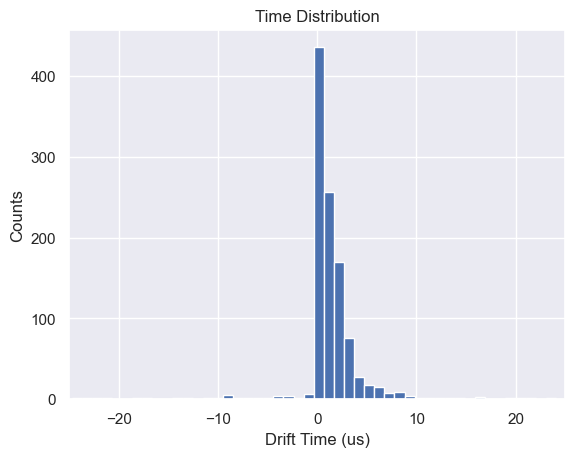

In [195]:
plt.hist([a for a in events_df['Drift_time'] if a > -1000], bins=200)
plt.title('Time Distribution')
plt.xlabel('Drift Time (us)')
plt.ylabel('Counts')
plt.xlim([-25, 25])
plt.show()

In [197]:
radii = calc_radius(events_df['Drift_time'])
Radius = pd.Series(data=radii, name='Radius')

events_df = pd.concat([events_df, Radius], axis=1)

In [198]:
events_df.head(20)

,Event,ID,Side,Layer,Column,R0,Trigger_time,Drift_time,Radius
0,0,0,1,0,7,847289447,847289131.5,3.94375,0.666290
1,0,1,1,8,0,847289127,847289131.5,-0.05625,NaN
2,0,2,1,5,3,847289197,847289131.5,0.81875,0.291284
3,0,3,1,6,2,847289122,847289131.5,-0.11875,NaN
4,0,4,1,1,7,847289281,847289131.5,1.86875,0.449727
5,0,5,1,1,6,847289437,847289131.5,3.81875,0.655090
6,0,6,1,7,1,847289134,847289131.5,0.03125,0.052221
7,0,7,1,4,4,847289144,847289131.5,0.15625,0.121821
8,0,8,1,0,8,847289316,847289131.5,2.30625,0.502378
9,0,9,1,6,60,847286043,847289131.5,-38.60625,NaN


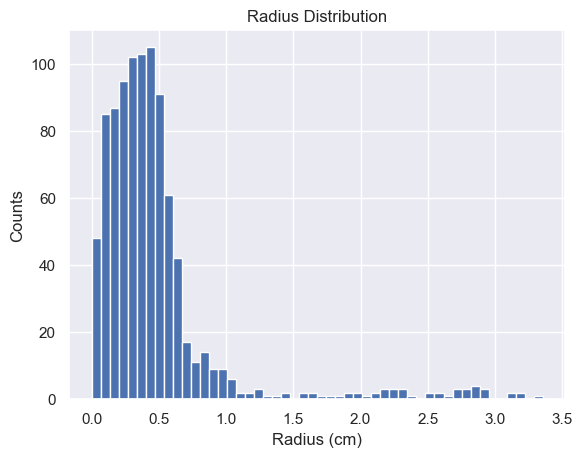

In [199]:
plt.hist(events_df['Radius'], bins=50)
plt.title('Radius Distribution')
plt.xlabel('Radius (cm)')
plt.ylabel('Counts')
plt.show()